In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

1A. Estimate stage of cirrhosis

In [2]:
df1 = pd.read_csv('1A.tsv', sep="\t")

A. Performing Exploratory Data Analysis (EDA)

In [3]:
print("\nData Information:")
print(df1.info())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       312 

In [4]:
print("\nSummary Statistics:")
print(df1.describe())


Summary Statistics:
               ID   Bilirubin  Cholesterol     Albumin      Copper  \
count  418.000000  418.000000    80.000000  418.000000  310.000000   
mean   209.500000    3.220813   358.662500    3.497440   97.648387   
std    120.810458    4.407506   230.414099    0.424972   85.613920   
min      1.000000    0.300000   149.000000    1.960000    4.000000   
25%    105.250000    0.800000   236.000000    3.242500   41.250000   
50%    209.500000    1.400000   284.500000    3.530000   73.000000   
75%    313.750000    3.400000   409.500000    3.770000  123.000000   
max    418.000000   28.000000  1480.000000    4.640000  588.000000   

       Alkaline Phospatase (U/L)        SGOT  Tryglicerides   Platelets  \
count                 312.000000  312.000000     418.000000  407.000000   
mean                 1982.655769  122.556346      83.803828  257.024570   
std                  2140.388824   56.699525      79.603693   98.325585   
min                   289.000000   26.350000    

In [5]:
print("\nChecking Missing Values:")
print(df1.isnull().sum())


Checking Missing Values:
ID                             0
Registration Date              0
Drug                         106
Birth Date                     0
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          6
dtype: int64


In [6]:
df1_cat = df1[['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']]

for i in df1_cat:
    print(df1[i].value_counts())
    print()

Drug
D-penicillamine    155
Placebo            152
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64

Gender
F    374
M     44
Name: count, dtype: int64

Ascites
N    288
Y     24
Name: count, dtype: int64

Hepatomegaly
Y    160
N    152
Name: count, dtype: int64

Edema
N    354
S     44
Y     20
Name: count, dtype: int64

Stage
stage_3    155
Stage4     144
Stage 2     92
Stage 1     21
Name: count, dtype: int64



Dapat lihat bahwa terdapat 10 kolom yang memiliki missing value, maka dari itu harus dilakukan handling terhadap semua missing value yang ada, dan juga terdapat anomali pada kolom Drug yang harus dibenarkan

Untuk data-data kategorical seperti Drug, Ascites, Hepatomegaly, dan Stage akan diisi dengan mode dari tiap kolom tersebut

In [7]:
#Categorical
df1['Drug'] = df1['Drug'].fillna(df1['Drug'].mode()[0])
df1['Ascites'] = df1['Ascites'].fillna(df1['Ascites'].mode()[0])
df1['Hepatomegaly'] = df1['Hepatomegaly'].fillna(df1['Hepatomegaly'].mode()[0])
df1['Stage'] = df1['Stage'].fillna(df1['Stage'].mode()[0])

In [8]:
print(df1.isnull().sum())

ID                             0
Registration Date              0
Drug                           0
Birth Date                     0
Gender                         0
Ascites                        0
Hepatomegaly                   0
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          0
dtype: int64


Untuk kolom Cholestrol karena memiliki missing value lebih besar dari 50% dari data asli maka dapat disimpulan bahwa kolom ini tidak perlu digunakna jadi bisa langsung kita hilangkan, sekalian menghilangkan kolom-kolom yang tidak berguna

In [9]:
missing_percentage = df1['Cholesterol'].isnull().mean() * 100
print(missing_percentage)

80.86124401913875


In [10]:
df1 = df1.drop(columns = ['ID', 'Registration Date', 'Birth Date', 'Cholesterol'])
df1.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


In [11]:
print(df1.isnull().sum())

Drug                           0
Gender                         0
Ascites                        0
Hepatomegaly                   0
Edema                          0
Bilirubin                      0
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          0
dtype: int64


Membenarkan Anomali pada colom Drug

In [12]:
val_dict = {
    'D-penicillamine': 'D-penicillamine',
    'd-penicillamine': 'D-penicillamine',
    'Placebo': 'Placebo',
    'placebo': 'Placebo',
    'lacebo': 'Placebo'
}

df1['Drug'] = df1['Drug'].map(val_dict)

df1['Drug'].value_counts()

Drug
D-penicillamine    264
Placebo            154
Name: count, dtype: int64

Melakukan Encoding pada kolom Stage

In [13]:
df1['Stage'] = df1['Stage'].replace({
    'Stage 1': '1',
    'Stage 2': '2', 
    'stage_3': '3', 
    'Stage4': '4'
})
df1.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3


Untuk kolom dengan tipe data numerical kita dapat mengisi missing value menggunakan median atau mean, untuk menentukan menggunakan median atau mean harus dilakukan pengecekan menggunakan boxplot jika terdapat outliers maka akan diisi menggunakan median dan jika tidak ada maka akan menggunakan mean

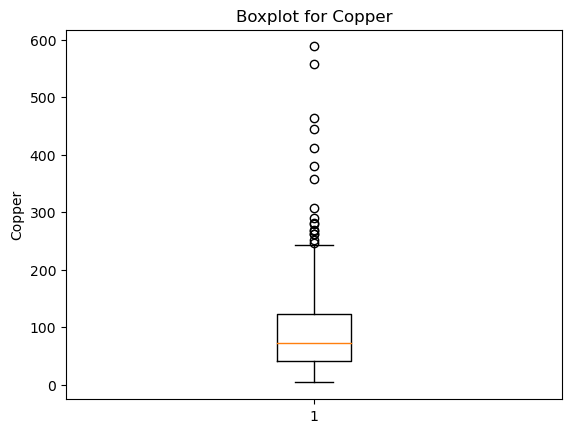

In [14]:
plt.boxplot(df1['Copper'].dropna())
plt.title('Boxplot for Copper')
plt.ylabel('Copper')
plt.show()

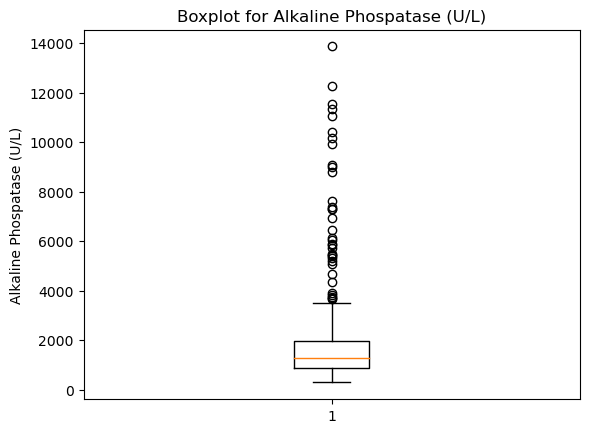

In [15]:
plt.boxplot(df1['Alkaline Phospatase (U/L)'].dropna())
plt.title('Boxplot for Alkaline Phospatase (U/L)')
plt.ylabel('Alkaline Phospatase (U/L)')
plt.show()

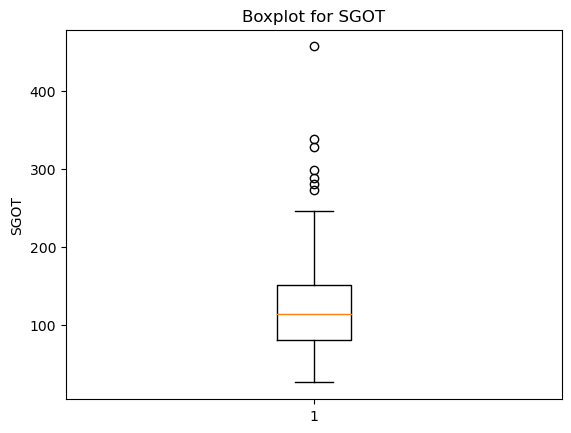

In [16]:
plt.boxplot(df1['SGOT'].dropna())
plt.title('Boxplot for SGOT')
plt.ylabel('SGOT')
plt.show()

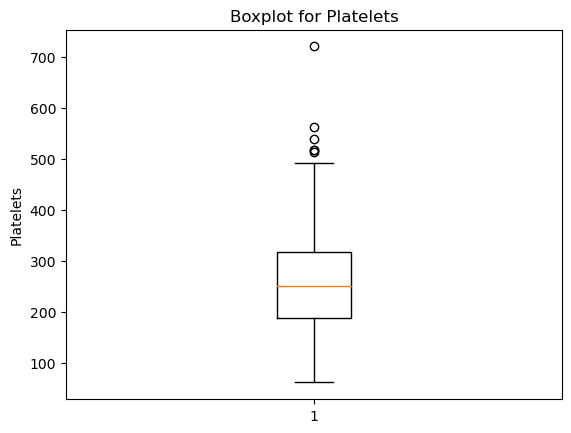

In [17]:
plt.boxplot(df1['Platelets'].dropna())
plt.title('Boxplot for Platelets')
plt.ylabel('Platelets')
plt.show()

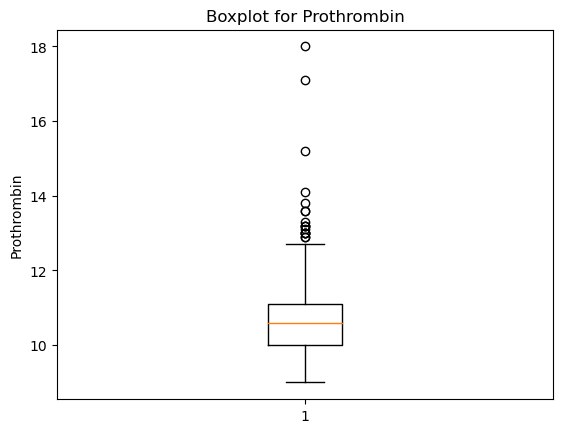

In [18]:
plt.boxplot(df1['Prothrombin'].dropna())
plt.title('Boxplot for Prothrombin')
plt.ylabel('Prothrombin')
plt.show()

Karena semua kolom memiliki outliers maka missing valuenya akan diisi menggunakan median

In [19]:
# Handling numerical missing value
df1['Copper'] = df1['Copper'].fillna(df1['Copper'].median())
df1['Alkaline Phospatase (U/L)'] = df1['Alkaline Phospatase (U/L)'].fillna(df1['Alkaline Phospatase (U/L)'].median())
df1['SGOT'] = df1['SGOT'].fillna(df1['SGOT'].median())
df1['Platelets'] = df1['Platelets'].fillna(df1['Platelets'].median())
df1['Prothrombin'] = df1['Prothrombin'].fillna(df1['Prothrombin'].median())

In [20]:
print(df1.isnull().sum())

Drug                         0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
dtype: int64


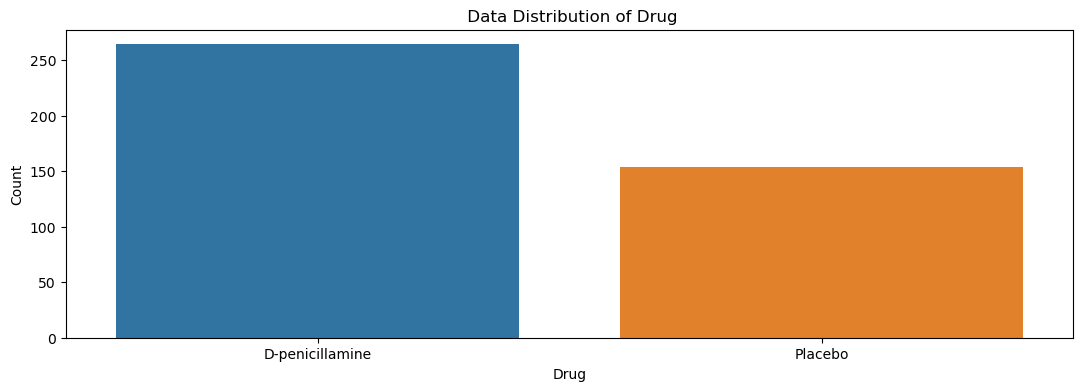

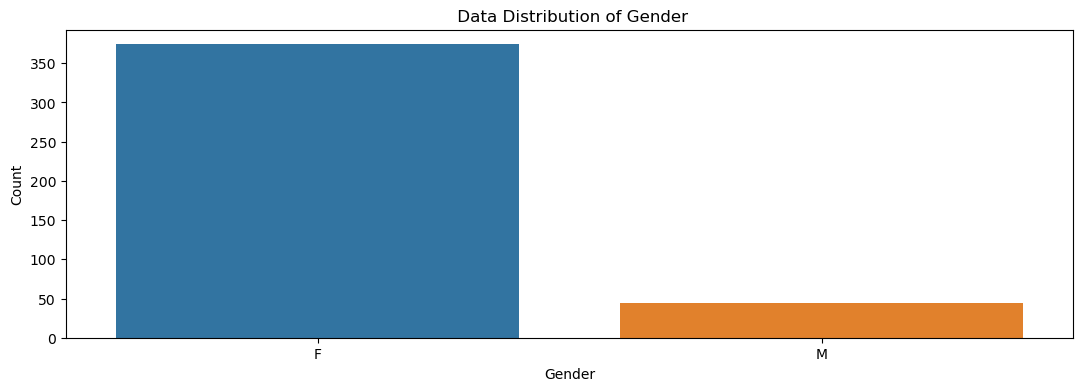

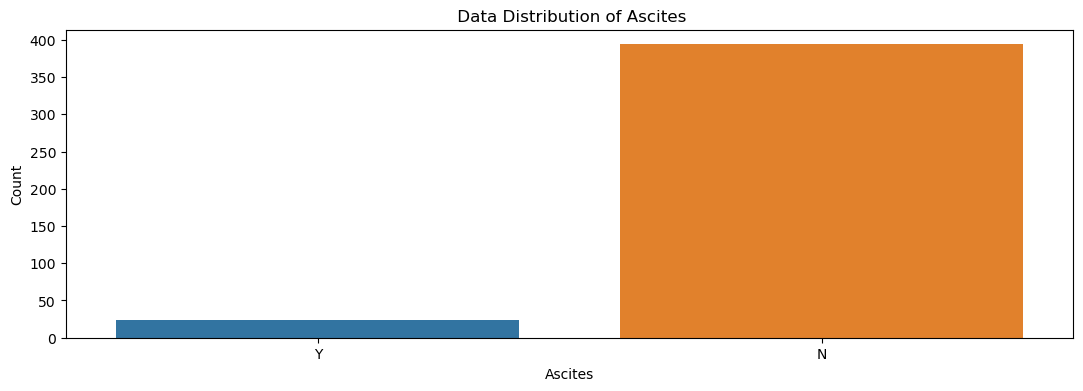

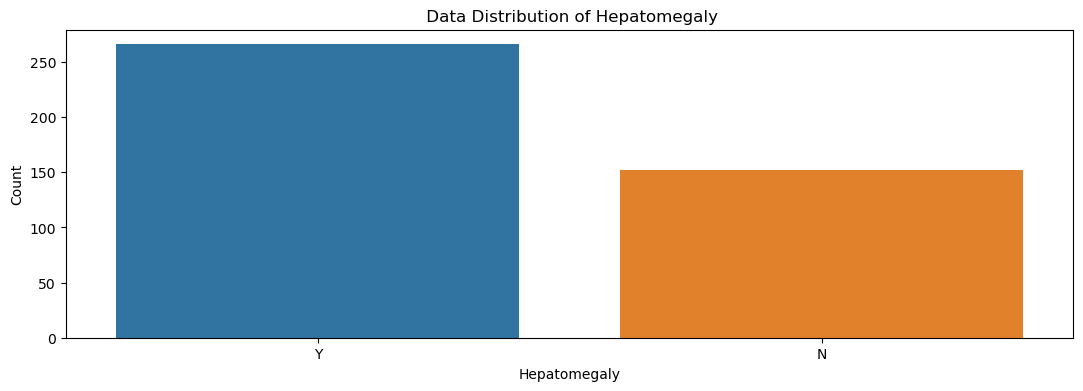

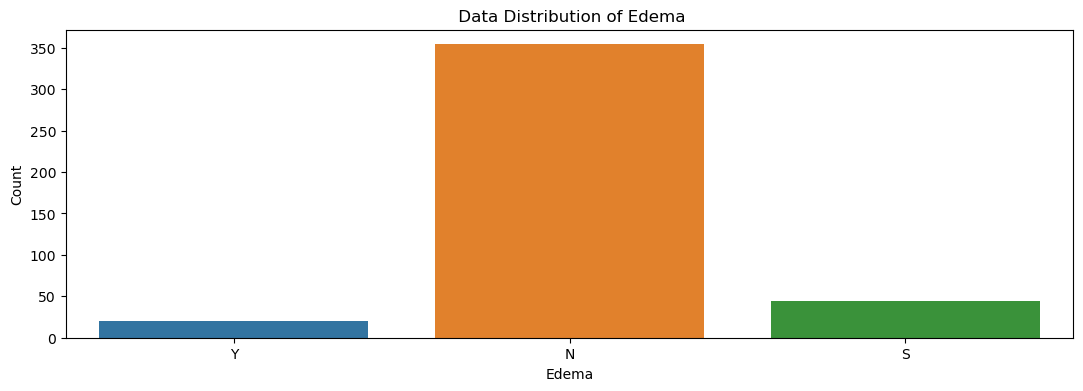

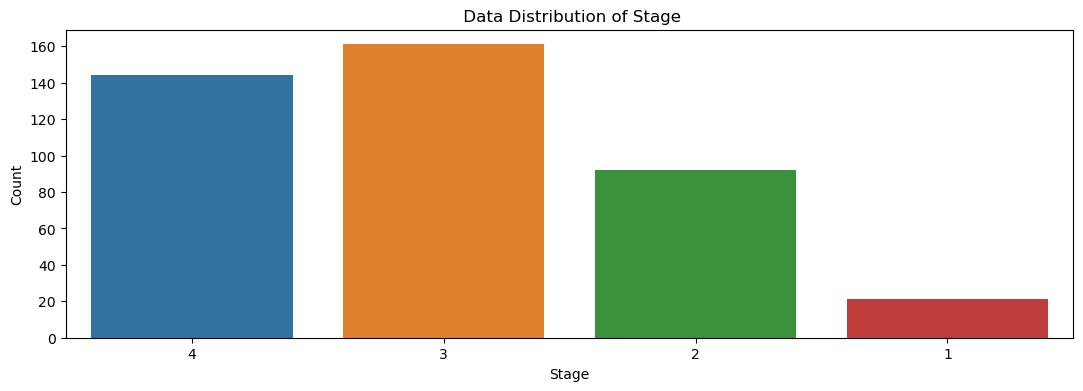

In [21]:
#Plotting the categorical variable 

df1_cat = df1.select_dtypes(include=['object']).columns.tolist()

for idx, feature in enumerate(df1_cat):
    plt.figure(figsize = (13,4))
    sns.countplot(data=df1, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(" Data Distribution of " + feature)
plt.show()

Dari hasil plot diatas terdapat beberapa hal yang dapat diambil:
1. obat yang paling banyak diberikan pada pasien adalah D-Penicillamine
2. pasien yang paling banyak terkena cirrhosis adalah perempuan
3. kebanyakan pasien tidak mengalami ascites
4. kebanyakan pasien mengalami hepatomegaly
5. kebanyakan pasien yang tercatat adalah pasien yang sudah dalam stage 3 dan 4

In [22]:
stages = df1.groupby('Stage')
stg_df = {stage: data.drop('Stage', axis=1) for stage, data in stages}

s1 = stg_df['1']
s2 = stg_df['2']
s3 = stg_df['3']
s4 = stg_df['4']

In [23]:
def categorical_distribution(col):
        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        sns.countplot(data=s1, x=col)
        plt.title(f'Stage 1 - {col}')

        plt.subplot(1, 4, 2)
        sns.countplot(data=s2, x=col)
        plt.title(f'Stage 2 - {col}')

        plt.subplot(1, 4, 3)
        sns.countplot(data=s3, x=col)
        plt.title(f'Stage 3 - {col}')

        plt.subplot(1, 4, 4)
        sns.countplot(data=s4, x=col)
        plt.title(f'Stage 4 - {col}')

        plt.show()

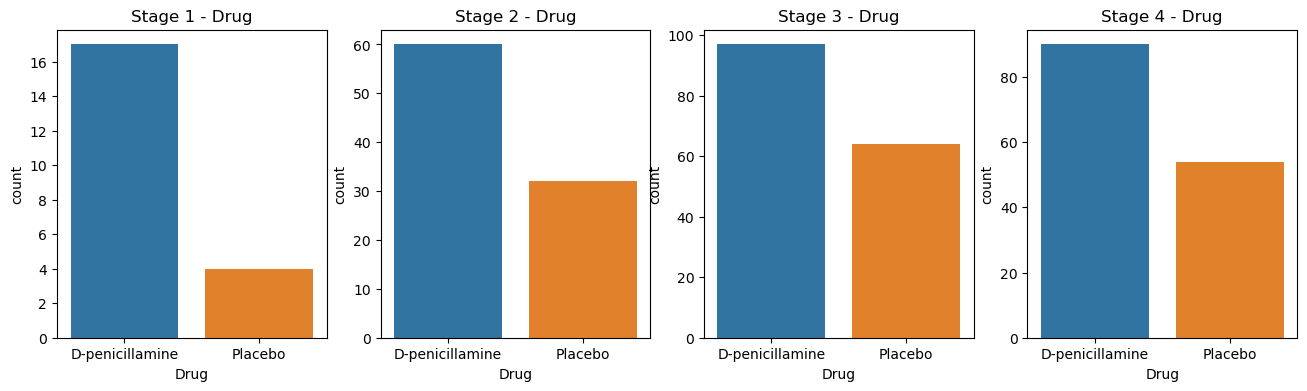

In [24]:
categorical_distribution('Drug')

Hasil dari histogram diatas menunjukan bahwa pasien lebih sering diberikan obat D-penicillamine dibandingkan dengan Placebo

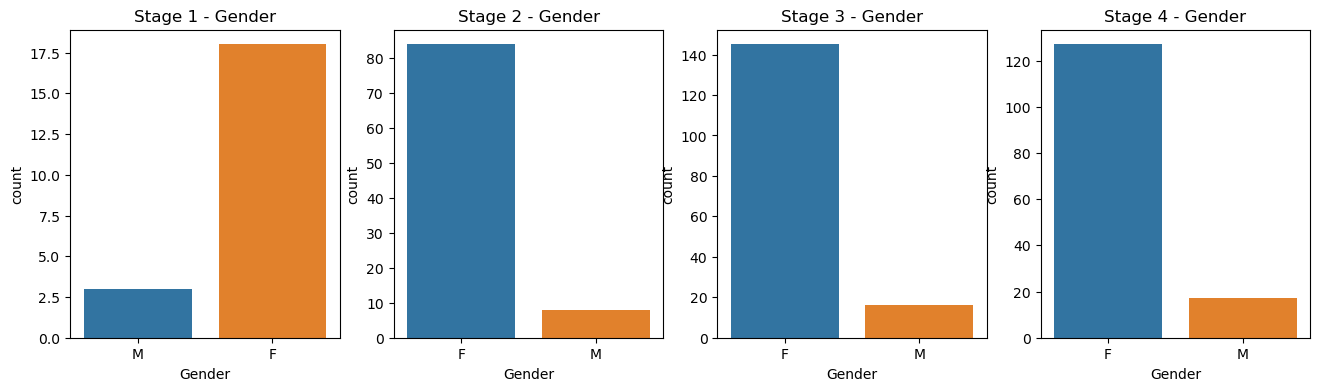

In [25]:
categorical_distribution('Gender')

Histogram diatas memberikan informasi bahwa kebanyakan pasien yang mengalami cirrhosis adalah perempuan

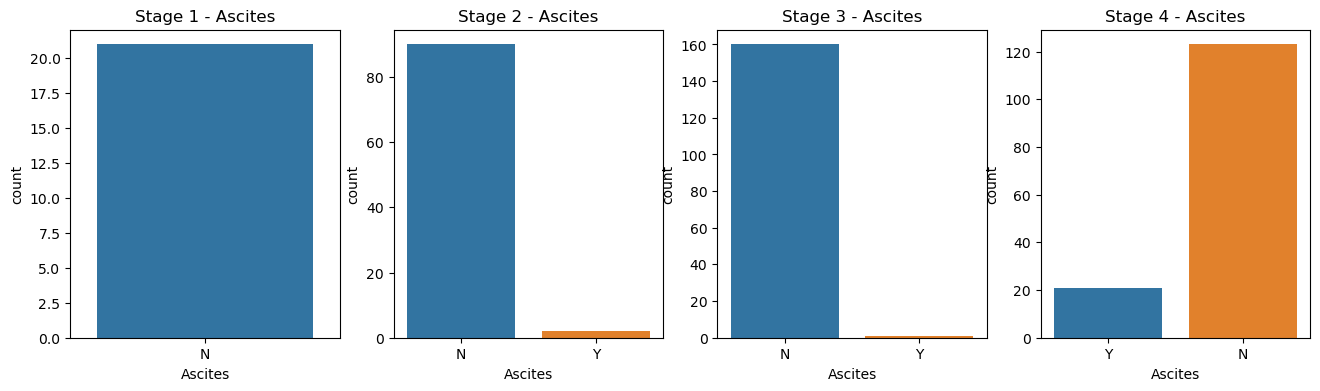

In [26]:
categorical_distribution('Ascites')

Dapat dilihat bahwa terdapat peningkatan Ascites pada paisen yang mengalami Cirrhosis di Stage 4

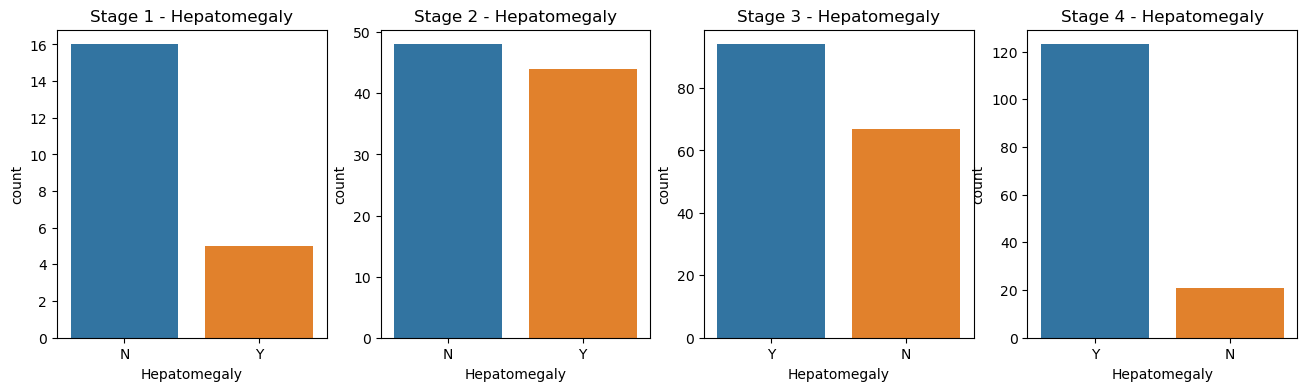

In [27]:
categorical_distribution('Hepatomegaly')

Dapat dilihat bahwa Hepatomegaly dialami oleh pasien pada tiap stage terutama pada stage 4

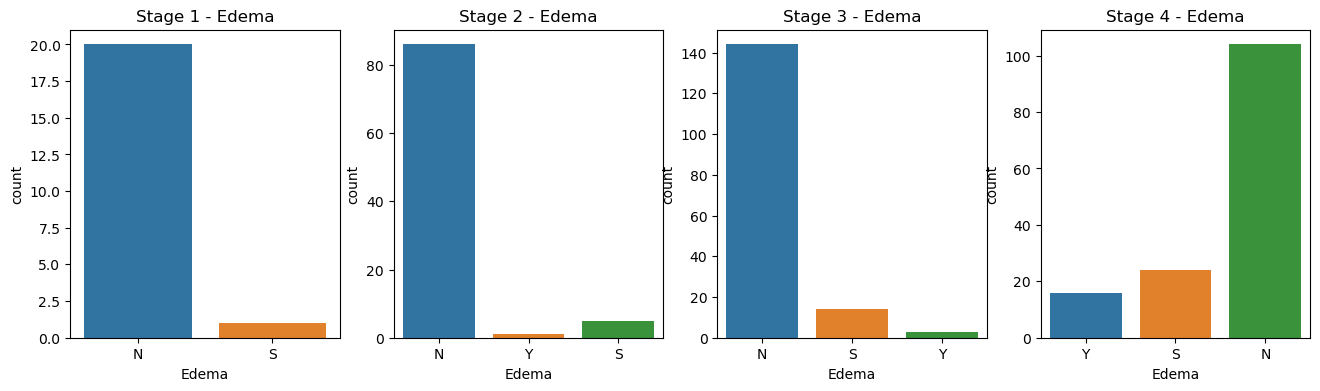

In [28]:
categorical_distribution('Edema')

S = Edema tanpa Diuretics
Y = Edema dan Diuretics

Dapat disimpulkan bahwa semakin tinggi stage yang diderita pasien maka semakin tinggi juga kemungkinan pasien menderita edema

Feature Engineering

In [29]:
df1['Bilirubin_Status'] = df1['Bilirubin'].apply(lambda x: 'Abnormal' if x > 1.2 else 'Normal')
df1['Albumin_Status'] = df1['Albumin'].apply(lambda x: 'Abnormal' if x < 5.4 or x > 3.4 else 'Normal')
df1['Copper_Status'] = df1['Copper'].apply(lambda x: 'Abnormal' if x > 140 else 'Normal') 
df1['Alkaline_Phosphatase_Status'] = df1['Alkaline Phospatase (U/L)'].apply(lambda x: 'Abnormal' if x > 147 else 'Normal')
df1['SGOT_Status'] = df1['SGOT'].apply(lambda x: 'Abnormal' if x > 40 else 'Normal')  
df1['Triglycerides_Status'] = df1['Tryglicerides'].apply(lambda x: 'Abnormal' if x > 150 else 'Normal')  
df1['Platelets_Status'] = df1['Platelets'].apply(lambda x: 'Abnormal' if x < 150 else 'Normal')  
df1['Prothrombin_Status'] = df1['Prothrombin'].apply(lambda x: 'Abnormal' if x < 70 else 'Normal')  
df1.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_Status,Albumin_Status,Copper_Status,Alkaline_Phosphatase_Status,SGOT_Status,Triglycerides_Status,Platelets_Status,Prothrombin_Status
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4,Abnormal,Abnormal,Abnormal,Abnormal,Abnormal,Abnormal,Normal,Abnormal
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3,Normal,Abnormal,Normal,Abnormal,Abnormal,Normal,Normal,Abnormal
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4,Abnormal,Abnormal,Abnormal,Abnormal,Abnormal,Normal,Normal,Abnormal
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4,Abnormal,Abnormal,Normal,Abnormal,Abnormal,Normal,Normal,Abnormal
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3,Abnormal,Abnormal,Abnormal,Abnormal,Abnormal,Normal,Abnormal,Abnormal


In [30]:
df1_status = ['Bilirubin_Status', 'Albumin_Status', 'Copper_Status', 'Alkaline_Phosphatase_Status', 'SGOT_Status', 'Triglycerides_Status', 'Platelets_Status', 'Prothrombin_Status']

def feature_analysis_plot(df, status_column):
    severity_analysis = pd.crosstab(df1['Stage'], df1[status_column])
    print(severity_analysis)
    
    severity_analysis.plot(kind='bar', stacked=False, figsize=(10, 5))
    plt.title(f'Status Distribution by Stage for {status_column}')
    plt.tight_layout()
    plt.show()

Bilirubin_Status  Abnormal  Normal
Stage                             
1                        4      17
2                       36      56
3                       83      78
4                      106      38


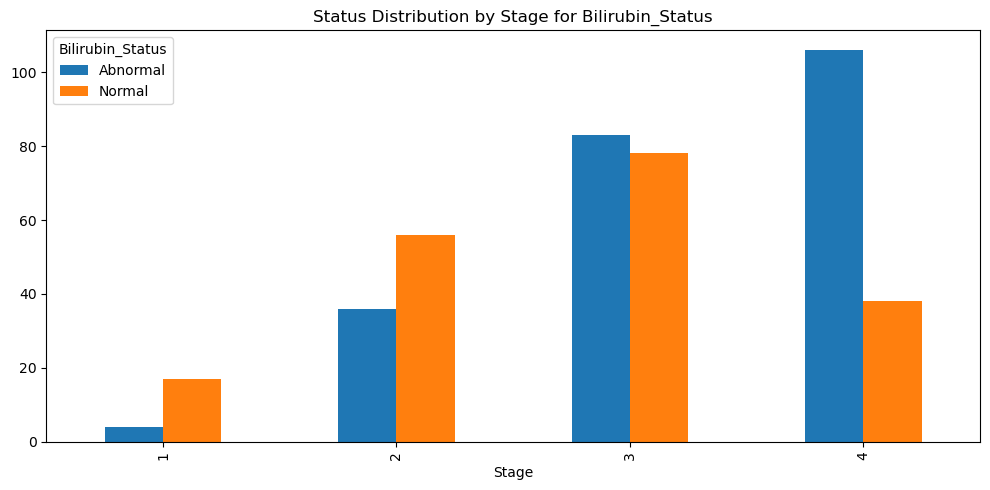

In [31]:
feature_analysis_plot(df1, 'Bilirubin_Status')

Copper_Status  Abnormal  Normal
Stage                          
1                     2      19
2                     9      83
3                    24     137
4                    32     112


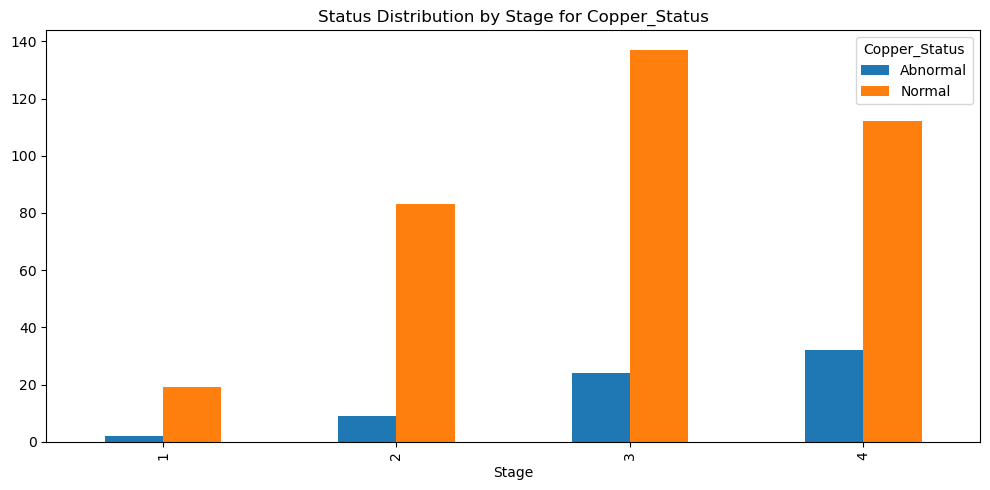

In [32]:
feature_analysis_plot(df1, 'Copper_Status')

SGOT_Status  Abnormal  Normal
Stage                        
1                  21       0
2                  91       1
3                 160       1
4                 144       0


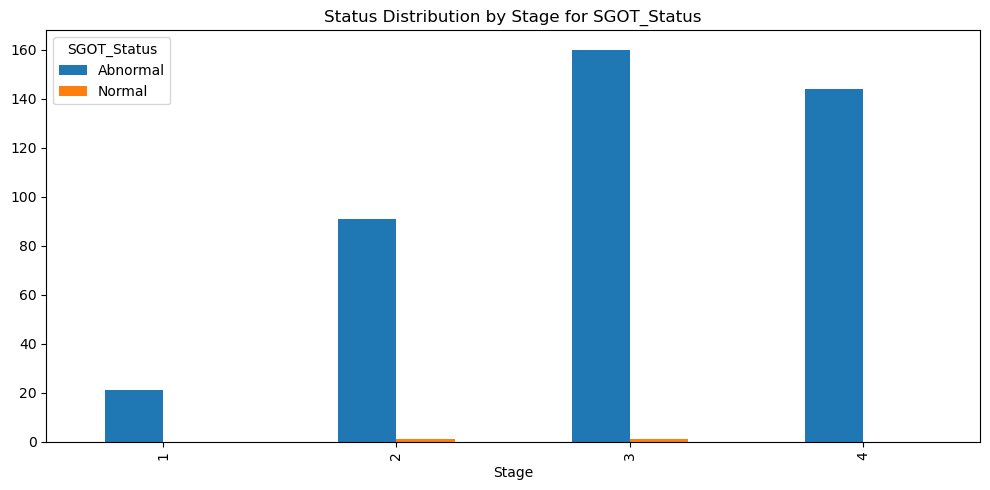

In [33]:
feature_analysis_plot(df1, 'SGOT_Status')

Triglycerides_Status  Abnormal  Normal
Stage                                 
1                            1      20
2                           11      81
3                           36     125
4                           24     120


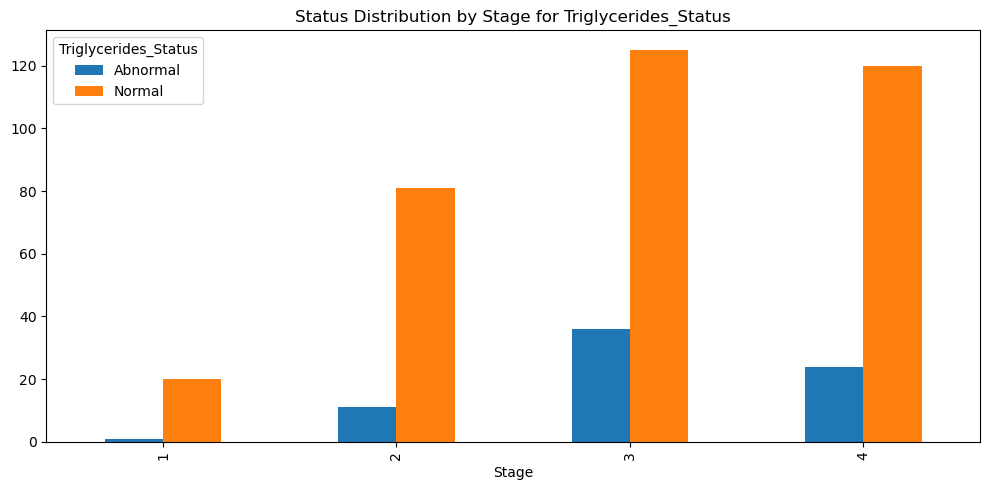

In [34]:
feature_analysis_plot(df1, 'Triglycerides_Status')

Platelets_Status  Abnormal  Normal
Stage                             
1                        1      20
2                        7      85
3                       14     147
4                       37     107


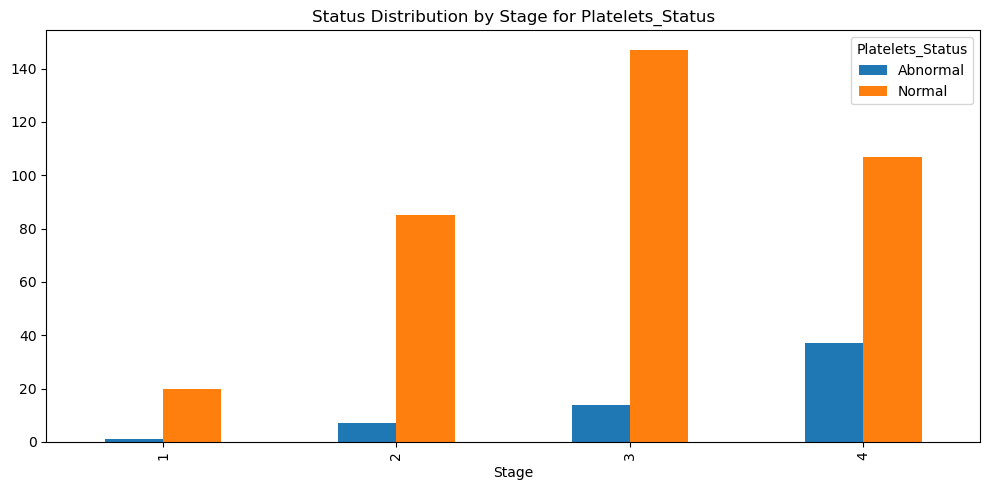

In [35]:
feature_analysis_plot(df1, 'Platelets_Status')

Corelation for numerical coloumn

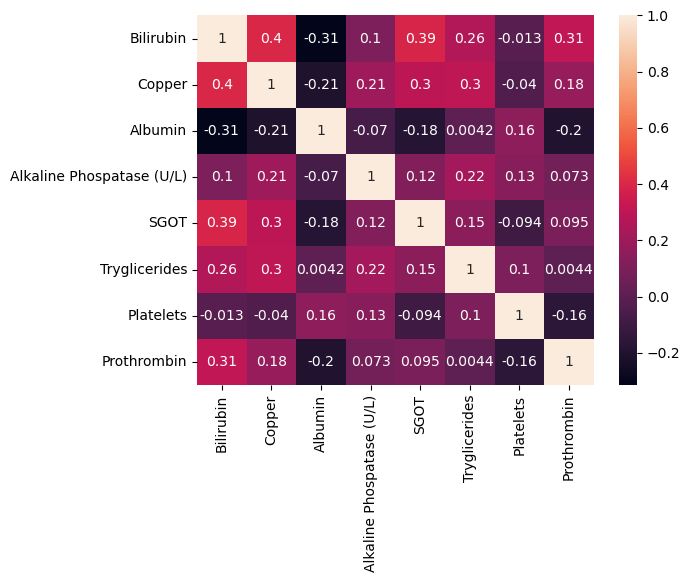

In [36]:
df1_numeric = df1[['Bilirubin', 'Copper', 'Albumin', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']]

sns.heatmap(df1_numeric.corr(), annot=True)
plt.show()

Plotting numerical values by Stage

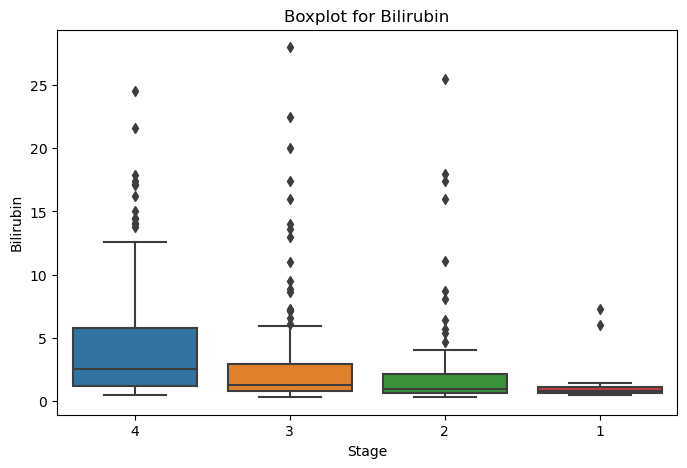

In [37]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Bilirubin'])
plt.title('Boxplot for Bilirubin')
plt.show()

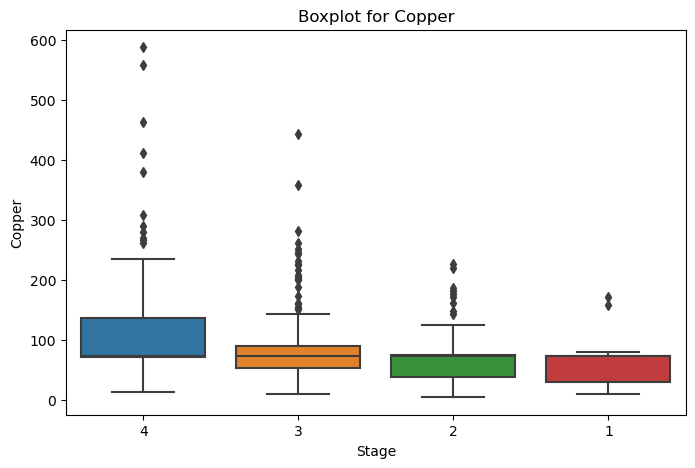

In [38]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Copper'])
plt.title('Boxplot for Copper')
plt.show()

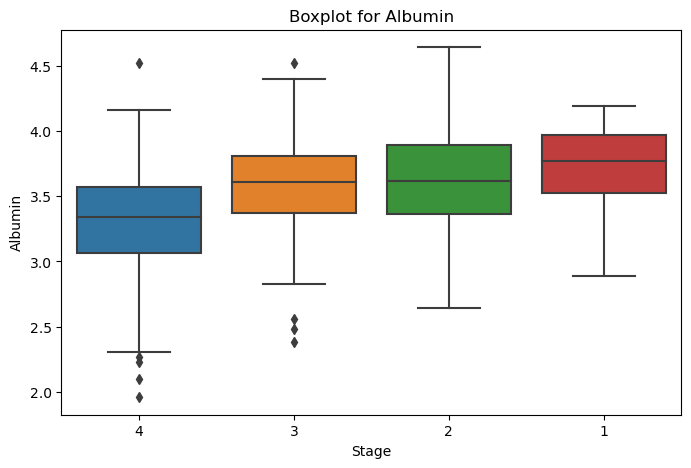

In [39]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Albumin'])
plt.title('Boxplot for Albumin')
plt.show()

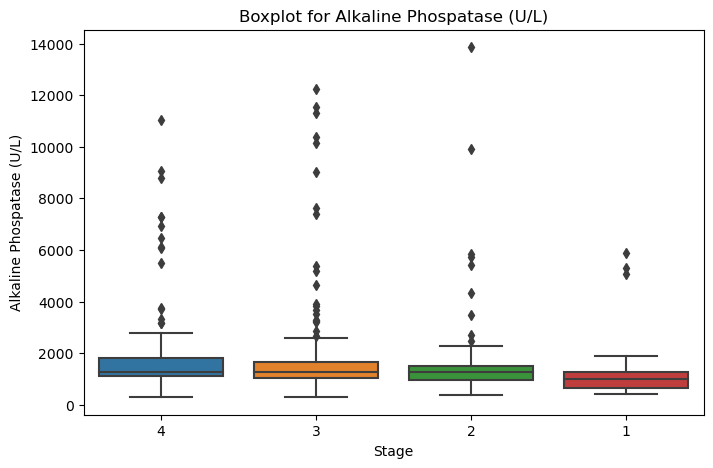

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Alkaline Phospatase (U/L)'])
plt.title('Boxplot for Alkaline Phospatase (U/L)')
plt.show()

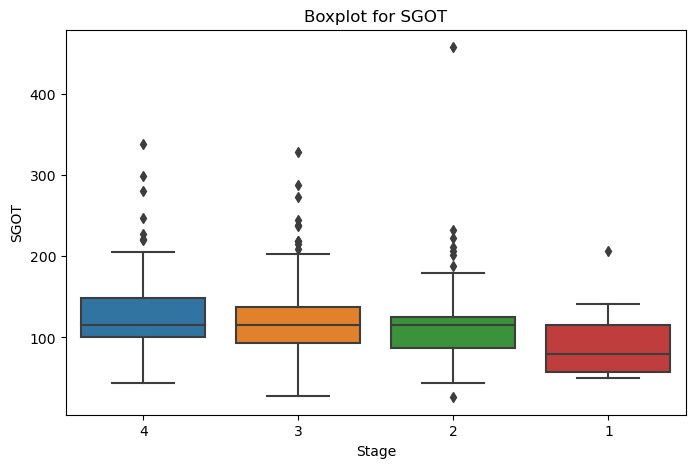

In [41]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['SGOT'])
plt.title('Boxplot for SGOT')
plt.show()

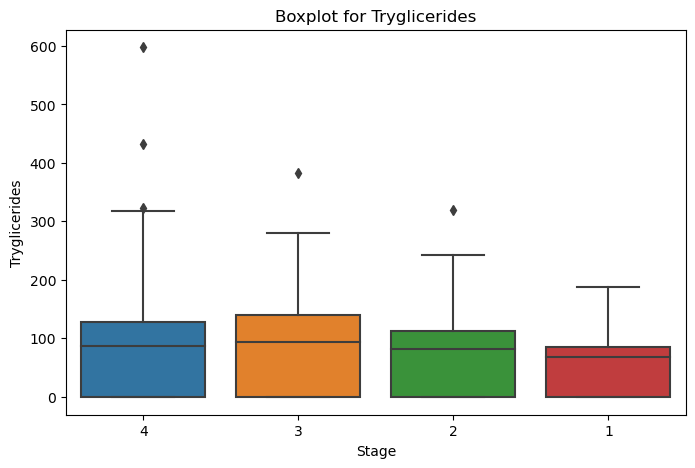

In [42]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Tryglicerides'])
plt.title('Boxplot for Tryglicerides')
plt.show()

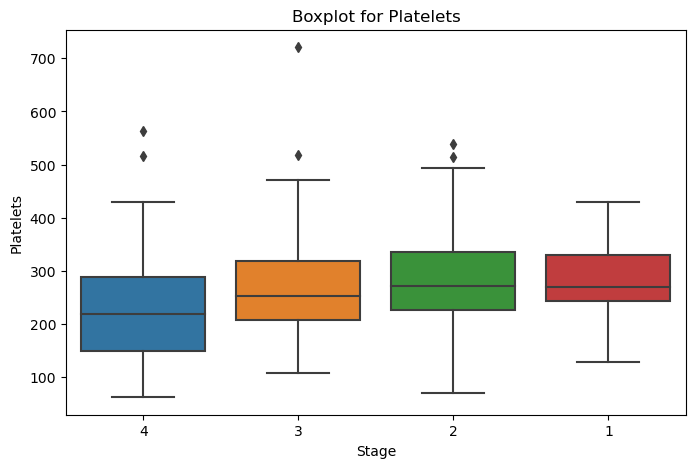

In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Platelets'])
plt.title('Boxplot for Platelets')
plt.show()

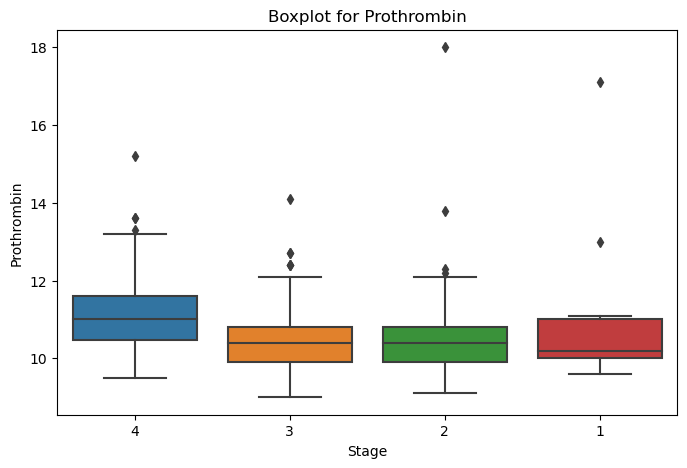

In [44]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df1['Stage'], y = df1['Prothrombin'])
plt.title('Boxplot for Prothrombin')
plt.show()

B. Model Training

drop unnecessary column

In [45]:
df1 = df1.drop(columns = ['Bilirubin_Status', 'Albumin_Status', 'Copper_Status', 'Alkaline_Phosphatase_Status', 'Triglycerides_Status', 'Platelets_Status', 'Prothrombin_Status', 'SGOT_Status'])
df1.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3


In [46]:
for i in df1_cat:
    print(df1[i].value_counts())
    print()

Drug
D-penicillamine    264
Placebo            154
Name: count, dtype: int64

Gender
F    374
M     44
Name: count, dtype: int64

Ascites
N    394
Y     24
Name: count, dtype: int64

Hepatomegaly
Y    266
N    152
Name: count, dtype: int64

Edema
N    354
S     44
Y     20
Name: count, dtype: int64

Stage
3    161
4    144
2     92
1     21
Name: count, dtype: int64



Encoding Categorical Column using LabelEncoder

In [47]:
catcol = df1.select_dtypes(include=['object', 'category']).columns

label_encoder = LabelEncoder()

for i in catcol:
    df1[i] = label_encoder.fit_transform(df1[i])
    
df1.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,0,1,1,2,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,3
1,0,0,0,1,0,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,2
2,0,1,0,0,1,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,3
3,0,0,0,1,1,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,3
4,1,0,0,1,0,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,2


Train Test Split

In [48]:
x = df1.drop(columns=['Stage'])
y = df1['Stage']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Analysis Metrics

In [49]:
def run_it (model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    predx = model.predict(x_test)
    
    print(classification_report(y_test,predx))

Initiate Modeling using Random Forest and XGBoost

In [50]:
#Random Forest
rf = RandomForestClassifier(random_state=123)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

#XGBoost
xgbs = xgb.XGBClassifier()
xgbs.fit(x_train, y_train)
xgbs_pred = xgbs.predict(x_test)

Random Forest pre-GridSearch

In [51]:
run_it(rf,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.09      0.06      0.07        16
           2       0.53      0.74      0.62        34
           3       0.69      0.58      0.63        31

    accuracy                           0.52        84
   macro avg       0.33      0.34      0.33        84
weighted avg       0.49      0.52      0.50        84



XGBoost pre-GridSearch

In [52]:
run_it(xgbs,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.12      0.06      0.08        16
           2       0.51      0.68      0.58        34
           3       0.64      0.58      0.61        31

    accuracy                           0.51        84
   macro avg       0.40      0.41      0.40        84
weighted avg       0.48      0.51      0.49        84



Make the Paramater grid for Random Forest and XGBoost

In [53]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.2, 0.4, 0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.75, 0.8, 1.0],
    'gamma' : [0, 0.1, 0.2]
}

Grid Search for Random Forest

In [54]:
rf_gridsearch = GridSearchCV(estimator = rf, 
                             param_grid = rf_param_grid,
                             cv=3, 
                             scoring='accuracy', 
                             n_jobs=-1)
rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [55]:
print('Random Forest Tuned Hyperparameter :', rf_gridsearch.best_params_)
print('Random Forest Best Accurracy: ', rf_gridsearch.best_score_)

Random Forest Tuned Hyperparameter : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Best Accurracy:  0.5208065208065208


Grid Search for XGBoost

In [56]:
xgb_gridsearch = GridSearchCV(estimator = xgbs,
                              param_grid = xgb_param_grid,
                              cv=3,
                              n_jobs=-1,
                              scoring='accuracy')
xgb_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.75, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]},
             scoring='accuracy')

In [57]:
print('XGBoost Tuned Hyperparameter :', xgb_gridsearch.best_params_)
print('XGBoost Best Accurracy: ', xgb_gridsearch.best_score_)

XGBoost Tuned Hyperparameter : {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.2}
XGBoost Best Accurracy:  0.5238899613899614


C. Model Evaluation Metrics Analysis

Random Forest

In [58]:
rf_2 = RandomForestClassifier(
    random_state=123, 
    criterion='gini', 
    max_depth=10, 
    min_samples_leaf=5, 
    min_samples_split=2, 
    n_estimators=50
)
rf_2.fit(x_train, y_train)
rf_pred = rf_2.predict(x_test)

XGBoost

In [59]:
run_it(rf_2,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.33      0.12      0.18        16
           2       0.57      0.76      0.65        34
           3       0.66      0.68      0.67        31

    accuracy                           0.58        84
   macro avg       0.39      0.39      0.37        84
weighted avg       0.53      0.58      0.54        84



In [60]:
xgbs_2 = xgb.XGBClassifier(
    colsample_bytree=0.5, 
    gamma=0.1, 
    learning_rate=0.01, 
    max_depth=6, 
    n_estimators=300, 
    subsample=0.2,
    random_state=123
)
xgbs_2.fit(x_train, y_train)
xgbs_pred = xgbs_2.predict(x_test)

In [61]:
run_it(xgbs_2,x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.06      0.10        16
           2       0.53      0.76      0.63        34
           3       0.67      0.65      0.66        31

    accuracy                           0.56        84
   macro avg       0.35      0.37      0.34        84
weighted avg       0.50      0.56      0.51        84



D. Model Evaluation

In [62]:
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

                      Feature  Importance
6                     Albumin    0.148958
11                  Platelets    0.145653
12                Prothrombin    0.139013
5                   Bilirubin    0.115826
10              Tryglicerides    0.088135
8   Alkaline Phospatase (U/L)    0.086847
7                      Copper    0.083780
9                        SGOT    0.083181
3                Hepatomegaly    0.043424
4                       Edema    0.020391
0                        Drug    0.016955
2                     Ascites    0.015067
1                      Gender    0.012771
